In [77]:
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier

In [40]:
# Load cleaned data into DataFrame
stroke_df = pd.read_csv('stroke_data_cleaned.csv')

# Preprocessing
Since the XGBoost classifier requires numerical inputs, I will first preprocess the data by seperating out and one-hot encoding the categorical features.  One-hot encoding is preferable over mapping to integer values since integer values have an inherent relationship due to their ordering.

In [41]:
# Seperate into data frames for the label, categorical features, and continuous features
label_df = stroke_df['stroke']
cat_df = stroke_df[['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]
non_cat_df = stroke_df[['age', 'avg_glucose_level', 'bmi']]

In [42]:
# Encode the categorical features
encoder = OneHotEncoder(sparse='false', drop='if_binary')
encoded_data = encoder.fit_transform(cat_df).toarray()

In [43]:
# Combine Categorical and continuous features
features = np.hstack((encoded_data, non_cat_df.to_numpy()))
features.shape

(4909, 19)

In [44]:
# Convert label dataframe to numpy column
labels = label_df.to_numpy().reshape(-1, 1)
labels.shape

(4909, 1)

# Split data into Train/Val/Test sets

In [49]:
seed = 42
val_size = 0.2
test_size = 0.2

In [52]:
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, \
                                                                    test_size=test_size, random_state=seed, shuffle=True)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, \
                                                                  test_size=val_size, random_state=seed, shuffle=True)

In [53]:
train_data.shape

(3141, 19)

# XGBoost Model Training

In [54]:
classifier_model = XGBClassifier()
classifier_model.fit(train_data, train_labels)

/Users/jamessalem/opt/anaconda3/envs/xgboost/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/jamessalem/opt/anaconda3/envs/xgboost/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamessalem/opt/anaconda3/envs/xgboost/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

[15:16:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluation
Because there are far fewer positive examples in the dataset, accuracy is not sufficient to tell us how well the model is performing.  For example, the model only successfully predicted 3 out of 29 strokes despite getting an accuracy of 95%.

In [56]:
val_predictions = classifier_model.predict(val_data)

In [81]:
# Compute Accuracy, Precision and Recall
accuracy = accuracy_score(val_labels, val_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
precision = precision_score(val_labels, val_predictions)
print("Precision: %.2f" % (precision))
recall = recall_score(val_labels, val_predictions)
print("Recall: %.2f" % (recall))

Accuracy: 95.55%
Precision: 0.25
Recall: 0.10


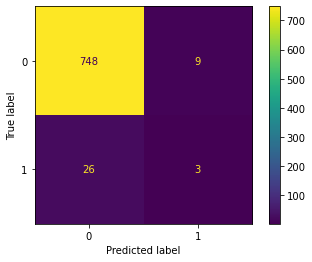

In [82]:
# Compute and Display the confusion matrix
conf_mat = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()

# Hyperparameter Tuning with Grid Search